In [1]:
__author__ = 'Alice Jacques <alice.jacques@noirlab.edu>, Robert Nikutta <robert.nikutta@noirlab.edu>, Astro Data Lab Team <datalab@noirlab.edu>' 
__version__ = '20220510' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['vhs_dr5', 'gaia_dr2']  
__keywords__ = ['stars','proper motions','crossmatch']

# Exploring Stellar Populations Around the Magellanic Clouds with VHS DR5
*by Alice Jacques, Robert Nikutta, & the Astro Data Lab Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Selection of young and old stellar populations around the LMC and SMC](#selection)
* [Extracting points in a region and querying for corresponding data](#extract)
* [Stellar proper motions](#pm)
* [Plot the spatial density morphology maps](#spatmorph)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
To reproduce Figures 3, 4, and 10 from [El Youssoufi et al. (2021)](https://arxiv.org/abs/2104.08054) "Stellar substructures in the periphery of the Magellanic Clouds with the VISTA Hemisphere Survey from the red clump and other tracers". These figures focus on detailing the morphological features in the outskirts of the Magellanic Clouds. In particular, this notebook will attempt to confirm the substructures noted in Figure 10 of the paper.

# Summary
In their paper, El Youssoufi et al. present a detailed analysis of the spatial distribution of different stellar populations in the periphery of the Magellanic Clouds (MCs) using data from the VISTA Hemisphere Survey ([VHS; McMahon et al. 2013](https://ui.adsabs.harvard.edu/abs/2013Msngr.154...35M/abstract)). In order to understand the ways in which the MCs interact with each other, it is very important to examine the stellar substructures that surround the MCs. We can use the VHS survey data to verify the existence of known substructures and discover new ones by studying the morphology surrounding the MCs over a continuous area.

NOTE: The paper also uses data from the VISTA near-infrared YJKs survey of the MCs system ([VMC; Cioni et al. 2011](https://ui.adsabs.harvard.edu/abs/2011A%26A...527A.116C/abstract)), which we will not be using in this notebook.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
from dl import queryClient as qc
import numpy as np
import pylab as plt
%matplotlib inline
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm
from shapely.geometry import Polygon, Point
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u

# plots default setup
plt.rcParams['font.size'] = 14

<a class="anchor" id="selection"></a>
## Selection of young and old stellar populations around the LMC and SMC
First we define the polygon regions that separate two different classes of objects: young stars (Y region) and old stars (O region). The polygon vertex coordinates listed here were first established by [Cioni et al. (2014)](https://arxiv.org/pdf/1306.4336.pdf) and [Cioni et al. (2016)](https://arxiv.org/pdf/1510.07647.pdf), then later refined in Section 2.1 of [El Youssoufi et al. (2019)](https://arxiv.org/pdf/1908.08545.pdf), and then refined further in Section 2.2 of their [2021 paper](https://arxiv.org/abs/2104.08054). The polygon vertices coordinates are in the J-Ks / Ks color-magnitude diagram.

In [3]:
# Define polygon regions
polygon_Y = Polygon([(-0.6, 18.8), (0.2, 18.8), (0.41, 17.5), (0.4,17.5), (0.18,17), (0,16.5), (0,16), (0.4,16), (0.4,16.5), (0.5,16), (1,10), (-0.6,10)])
polygon_O = Polygon([(0.18,18.8), (0.6,18.8), (0.6,16), (1.2,12), (2.5,12), (2.5,10), (1,10), (0.5,16), (0.4, 16.5), (0.4,17.5)])

Here we write the query to extract the Ks magnitude and J-Ks color from the VHS DR5 vhs_cat_v3 table for points that are near the LMC and SMC. Since this query returns over 37 million rows and takes nearly 20 minutes to run, we only print the contents of the query and comment out the actual running of the query. We screenshot the resulting plot and show it below to compare with the leftmost plot in Figure 3 of [El Youssoufi et al. (2021)](https://arxiv.org/abs/2104.08054).

In [4]:
q = """
SELECT 
    jmkspnt,ksapermag3 
FROM
    vhs_dr5.vhs_cat_v3
WHERE
    jmkspnt!='NaN' AND ksapermag3 !='NaN' AND japermag3 !='NaN'
    AND (dec2000<=-49.73 AND dec2000>-99.73)
    AND ((ra2000<=130 AND ra2000>0) OR (ra2000<=360 AND ra2000>340))
"""
print(q)


SELECT 
    jmkspnt,ksapermag3 
FROM
    vhs_dr5.vhs_cat_v3
WHERE
    jmkspnt!='NaN' AND ksapermag3 !='NaN' AND japermag3 !='NaN'
    AND (dec2000<=-49.73 AND dec2000>-99.73)
    AND ((ra2000<=130 AND ra2000>0) OR (ra2000<=360 AND ra2000>340))



In [5]:
%%time
# this query will run for about 3 minutes
res = qc.query(sql=q, timeout=600, fmt='pandas')

CPU times: user 14.9 s, sys: 7.43 s, total: 22.3 s
Wall time: 6min 1s


We define a little helper function to make computing 2D histograms easier.

In [6]:
def compute_nbins(x,y,binsize,extent=None):
    """Compute the needed number of x and y bins.
    
    From the x and y data, and the desired binsize (identical for x and y),
    computes the number of needed x and y bins. If 'extent' is given, trim
    x and y data to the limits given in 'extent' first. Otherwise, use the
    full data range.
    
    Parameters:
    -----------
    n, x : 1D arrays
      The x and y data to bin in 2D.
      
    binsize : float
      The desired bin size (identical for x and y), in the units of x and y.
      
    extent : tuple
      Optional. If not None, it is a 4-tuple (xmin,xmax,ymin,ymax).
      
    Returns:
    --------
    x, y : 1D arrays
      If extent=None, the returned x and y are identical to the input x and y.
      Otherwise they are trimmed to the [xmin,xmax] and [ymin,ymax] ranges
      defined in 'extent'.
    """
    
    if extent is not None:
        xmin, xmax, ymin, ymax = extent
        select = (x >= xmin) & (x <= xmax) & (y >= ymin) & (y <= ymax)
        x = x[select]
        y = y[select]
    else:
        xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
        
    nxbins = int((xmax-xmin)/binsize)
    nybins = int((ymax-ymin)/binsize)

    return x, y, nxbins, nybins

And we define a plotting function to simplify plotting of color-magnitude diagrams:

In [7]:
def plot_cmd(x,y,title,extent=None,binsize=0.02):
    """Plot a color-magnitude diagram from color (x) and magnitude (y) sequences."""
 
    # get number of x and y bins, given a target bin size (magnitude bins for a CMD)
    x, y, nxbins, nybins = compute_nbins(x,y,binsize,extent)
    
    # plot 2D histogram
    fig, ax = plt.subplots(1,1,figsize=(10,8))
    hmap,xedges,yedges,im = ax.hist2d(x, y, (nxbins, nybins), norm=LogNorm(), cmap=plt.cm.jet)
    ax.set_title(title)
    ax.set_xlabel('J-Ks (mag)')
    ax.set_ylabel('Ks (mag)')
    ax.invert_yaxis()
    
    # plot polygons
    ax.plot(*polygon_Y.exterior.xy, 'k-', lw=3)
    ax.plot(*polygon_O.exterior.xy, 'k-', lw=3)

    # label polygons
    ax.text(-0.5,10.8,'Y',fontsize=30)
    ax.text(2.2,10.8,'O',fontsize=30)

    plt.colorbar(im,label="objects per magnitude bin (%g x %g mag)" % (binsize,binsize))

We can now plot the pre-crossmatch CMD:

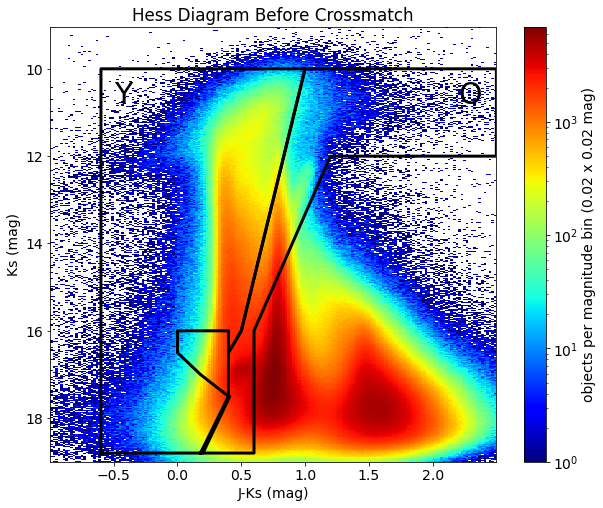

In [8]:
x_t = res['jmkspnt']
y_t = res['ksapermag3']
extent = (-1,2.5,9,19) # xmin, xmax, ymin, ymax
plot_cmd(x_t,y_t,'Hess Diagram Before Crossmatch',extent=extent,binsize=0.02)

Compare this plot to Figure 3 (left panel) in [El Youssoufi et al. (2021)](https://arxiv.org/abs/2104.08054). The color scale indicates the stellar density on a logarithmic scale. Stars within the small polygonal area (16 ≤ Ks ≤ 17.5 mag) are not included in the study as they have mixed ages. Enclosed by solid black lines are two different classes of objects: Y referring to young stars and O referring to old stars. The Y and O regions result from the combination of CMD regions established by [El Youssoufi et al. (2019)](https://arxiv.org/abs/1908.08545).

**Region Y:**  
- Populated by young stars, including the top of the main sequence and supergiant stars.
- Contains regions A, B, C, I, G, and H from [El Youssoufi et al. (2019)](https://arxiv.org/abs/1908.08545).

**Region O:**  
- Populated by old stars, including the red giant branch, asymptotic giant branch, and RC stars.
- Contains regions D, E, J, K, and M from [El Youssoufi et al. (2019)](https://arxiv.org/abs/1908.08545). 

**Both regions Y and O:**  
- Limited to Ks = 18.8 mag instead of Ks = 19.8 mag, to reflect the sensitivity of the VHS observations.
- Has been extended to Ks = 10 mag, instead of Ks = 11.98 mag and to J-Ks = -0.6 mag instead of J-Ks = -0.2 mag, to maximize the number of stars after their crossmatch with Gaia DR2 (see next plot).


## Query with constraints
Now we query the VHS DR5, Gaia DR2, and pre-computed crossmatch table between VHS DR5 and Gaia DR2 to extract the magnitudes, parallax, and proper motion values with the following constraints:
- Magnitudes exist
- Proper motions exist
- Parallaxes are <=0.2 mas
- Objects are unique (priorsec<=0 or priorsec=framesetid)
- Classified as stars with at least 70% probability (flag mergedclass = −1 or mergedclass = −2)
- Photometric errors are less than 0.2 mag
- RA is between 0 and 130 or between 340 and 360
- Dec is between -119.73 and -39.73

In [9]:
query_xmatch = """
SELECT 
    X.ra1 AS ra_vhs, X.dec1 AS dec_vhs,
    (V.jmkspnt - 0.011) AS jmkspnt, (V.ksapermag3 + 0.011) AS ksapermag3, 
    G.parallax, G.pmra, G.pmdec
FROM
    vhs_dr5.x1p5__vhs_cat_v3__gaia_dr2__gaia_source AS X 
JOIN
    gaia_dr2.gaia_source AS G ON X.id2 = G.source_id
JOIN
    vhs_dr5.vhs_cat_v3 AS V ON X.id1 = V.sourceid
WHERE
    jmkspnt!='NaN' AND ksapermag3 !='NaN' AND japermag3 !='NaN'
    AND parallax<=0.2
    AND (priorsec<=0 OR priorsec = framesetid)
    AND (mergedclass=-1 OR mergedclass=-2)
    AND ksapermag3err<0.2 AND japermag3err<0.2
    AND pmra !='NaN' AND pmdec !='NaN'
    AND pmra BETWEEN -2.25 AND 4.5
    AND pmdec BETWEEN -2.25 AND 2.25
    AND dec1 BETWEEN -119.73 AND -39.73
    AND ((ra1 BETWEEN 0 AND 130) OR (ra1 BETWEEN 340 and 360))
"""

print(query_xmatch) # print the query statement to screen


SELECT 
    X.ra1 AS ra_vhs, X.dec1 AS dec_vhs,
    (V.jmkspnt - 0.011) AS jmkspnt, (V.ksapermag3 + 0.011) AS ksapermag3, 
    G.parallax, G.pmra, G.pmdec
FROM
    vhs_dr5.x1p5__vhs_cat_v3__gaia_dr2__gaia_source AS X 
JOIN
    gaia_dr2.gaia_source AS G ON X.id2 = G.source_id
JOIN
    vhs_dr5.vhs_cat_v3 AS V ON X.id1 = V.sourceid
WHERE
    jmkspnt!='NaN' AND ksapermag3 !='NaN' AND japermag3 !='NaN'
    AND parallax<=0.2
    AND (priorsec<=0 OR priorsec = framesetid)
    AND (mergedclass=-1 OR mergedclass=-2)
    AND ksapermag3err<0.2 AND japermag3err<0.2
    AND pmra !='NaN' AND pmdec !='NaN'
    AND pmra BETWEEN -2.25 AND 4.5
    AND pmdec BETWEEN -2.25 AND 2.25
    AND dec1 BETWEEN -119.73 AND -39.73
    AND ((ra1 BETWEEN 0 AND 130) OR (ra1 BETWEEN 340 and 360))



In [10]:
%%time
# this query will run for about 1m30s
re_xmatch = qc.query(sql=query_xmatch,fmt='pandas',timeout=600)
re_xmatch

CPU times: user 3.57 s, sys: 1.7 s, total: 5.26 s
Wall time: 1min 48s


,ra_vhs,dec_vhs,jmkspnt,ksapermag3,parallax,pmra,pmdec
0,340.110370,-42.967672,0.348407,16.871744,0.075141,-0.255269,-2.182790
1,340.129188,-43.085605,0.749611,17.644465,-0.108369,0.872081,-0.417749
2,340.042872,-43.160891,0.713365,17.001383,-0.537741,3.517744,0.897946
3,340.672597,-43.280895,0.292122,17.576849,0.143384,3.228587,-1.908307
4,340.098781,-42.938750,0.683088,18.457476,-3.901395,1.180686,0.159095
...,...,...,...,...,...,...,...
1404191,39.250646,-39.813556,0.335273,18.436283,-0.092082,3.032954,-1.703972
1404192,42.926752,-39.773407,1.259702,17.546362,-0.392277,0.081393,0.356748
1404193,42.843076,-39.772547,0.474300,16.734888,0.108844,2.671371,-2.122325
1404194,38.666694,-39.751764,0.923055,16.509762,-0.150561,-0.001685,0.016169


We can now plot the CMD again, this time post-crossmatching:

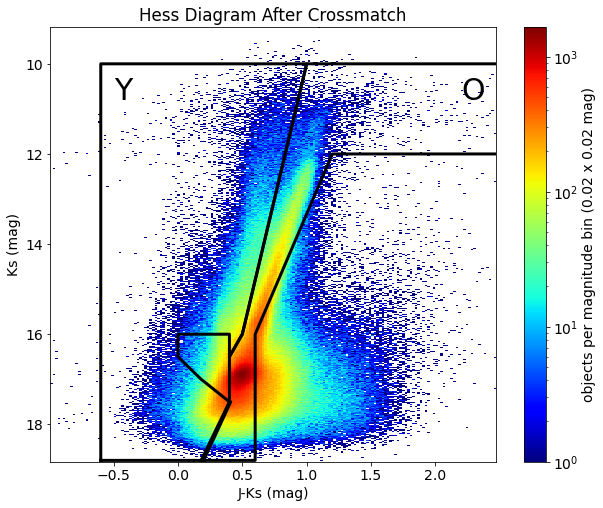

In [11]:
x_after = re_xmatch['jmkspnt']
y_after = re_xmatch['ksapermag3']
plot_cmd(x_after,y_after,'Hess Diagram After Crossmatch',extent=extent,binsize=0.02)

Compare this plot to Figure 3 (middle panel) in [El Youssoufi et al. (2021)](https://arxiv.org/abs/2104.08054).

<a class="anchor" id="extract"></a>
## Extracting points only in the Y or O region, then querying for corresponding data
Now we will extract points that fall within the Y, O, and Y+O polygon regions. We will use these sets of points to query the `re_xmatch` table for corresponding data (RA, Dec, parallax, and proper motions). For that, we first define a few helpful functions.

In [12]:
def extract_points_in_polygon(x_points, y_points, polygon):
    """ 
    Given a list of x_points and y_points, and a Polygon object, return the
    x and y coordinates (as two separate lists) of the points that are
    contained within the polygon.
    """
    
    keep = []
    for xy in zip(x_points,y_points):
        if polygon.contains(Point(xy)):
            keep.append(xy)
       
    return [_[0] for _ in keep], [_[1] for _ in keep]

In [13]:
def query_region(x,y,polygon,region):
    """
    Given a list of x coordinates, a list of y coordinates, and a Polygon
    object, query the results from the cross-match for data that falls 
    within the specified polygon. 
    """
    x_poly, y_poly = extract_points_in_polygon(x,y,polygon)
    y_poly_sub = []
    x_poly_add = []
    
    for i in range(len(y_poly)):
        y_poly_sub.append(y_poly[i])
    for i in range(len(x_poly)):
        x_poly_add.append(x_poly[i])
    res_poly1 = re_xmatch.query("ksapermag3 == @y_poly_sub and jmkspnt == @x_poly_add") 
    
    if region == 'Y':
        bads_Y1 = res_poly1.loc[(res_poly1['ksapermag3'] > 16.4) & (res_poly1['jmkspnt'] > 0.41)]
        bads_list_Y1 = list(bads_Y1.index)
        res = res_poly1.drop(bads_list_Y1) #  Remove points outside of the Y region.
    elif region == 'O':
        bads_O1 = res_poly1.loc[(res_poly1['ksapermag3'] < 18.2) & (res_poly1['ksapermag3'] > 16) & (res_poly1['jmkspnt'] > 0.61)]
        bads_O2 = res_poly1.loc[(res_poly1['ksapermag3'] < 17.8) & (res_poly1['ksapermag3'] > 16) & (res_poly1['jmkspnt'] < 0.399)]
        bads_list_O1 = list(bads_O1.index)
        bads_list_O2 = list(bads_O2.index)
        res_O_drop1 = res_poly1.drop(bads_list_O1)
        res = res_O_drop1.drop(bads_list_O2) #  Remove points outside of the O region.
        
    return res

In [14]:
%%time
# this cell will run for about 1m30s
res_Y = query_region(x_after, y_after, polygon_Y, 'Y')
res_O = query_region(x_after, y_after, polygon_O, 'O')

CPU times: user 1min 39s, sys: 232 ms, total: 1min 39s
Wall time: 1min 39s


### Combine Y+O region data
Here we concatenate the `res_Y` and `res_O` tables.

In [15]:
frames = [res_Y, res_O]
res_YO = pd.concat(frames)
res_YO

,ra_vhs,dec_vhs,jmkspnt,ksapermag3,parallax,pmra,pmdec
3,340.672597,-43.280895,0.292122,17.576849,0.143384,3.228587,-1.908307
5,341.014108,-43.358324,0.292224,15.949987,0.132070,1.612944,-2.088666
16,340.650934,-42.923638,0.173347,17.894827,-0.662611,2.323826,-0.621560
19,340.882836,-43.074753,0.500894,13.601856,0.050497,0.733171,-1.282724
20,340.789684,-43.146205,0.042642,18.720045,-0.033655,2.936464,-1.923738
...,...,...,...,...,...,...,...
1404185,39.860460,-39.797725,0.412969,18.151194,-0.063119,0.292212,-1.259920
1404186,39.831593,-39.774345,0.563368,18.235483,-1.857436,1.043354,-0.668672
1404187,39.783129,-39.771551,0.430093,16.777142,-0.259627,2.330348,-0.808386
1404191,39.250646,-39.813556,0.335273,18.436283,-0.092082,3.032954,-1.703972


<a class="anchor" id="pm"></a>
## Stellar Proper Motions in Y+O regions
Now we will apply a proper motion selection. We examine the stellar density of objects belonging to regions Y and O in proper motion space, and determine two ellipses around the LMC and SMC distributions in proper motion space.

In [16]:
LMC_ellipse = Ellipse((1.7,0.4),1,2.2,15)  # args are: (x0,y0), xwidth, ywidth, angle (in degrees, anti-clockwise)
LMC_vertices = LMC_ellipse.get_verts()     # get the vertices from the ellipse object
LMC_ellipse = Polygon(LMC_vertices)        # Turn it into a polygon

SMC_ellipse = Ellipse((0.9,-1.2),1.2,0.5,0)
SMC_vertices = SMC_ellipse.get_verts()     # get the vertices from the ellipse object
SMC_ellipse = Polygon(SMC_vertices)        # Turn it into a polygon

In [17]:
def plot_pm_diagram(x,y,extent=None,binsize=0.006):

    # get number of x and y bins, given the desired binsize
    x, y, nxbins, nybins = compute_nbins(x,y,binsize,extent)

    # plot
    fig, ax = plt.subplots(1,1,figsize=(14,8))
    hmap, xedges, yedges, im = plt.hist2d(x, y, (nxbins, nybins), cmap=plt.cm.jet, norm=LogNorm())
    plt.plot(*LMC_ellipse.exterior.xy,'w',lw=3)
    plt.plot(*SMC_ellipse.exterior.xy,'w',lw=3)
    ax.set_title('Stellar Proper Motion Distributions')
    ax.set_xlabel('$\mu_{RA}$ (mas $yr^{-1}$)')
    ax.set_ylabel('$\mu_{Dec}$ (mas $yr^{-1}$)')
    ax.text(-2,-2,'Y + O',fontsize=30,color='k',family='serif')
    
    plt.colorbar(im,label=r"objects per bin (%g x %g $\rm mas\,\, yr^{-1}$)" % (binsize,binsize))

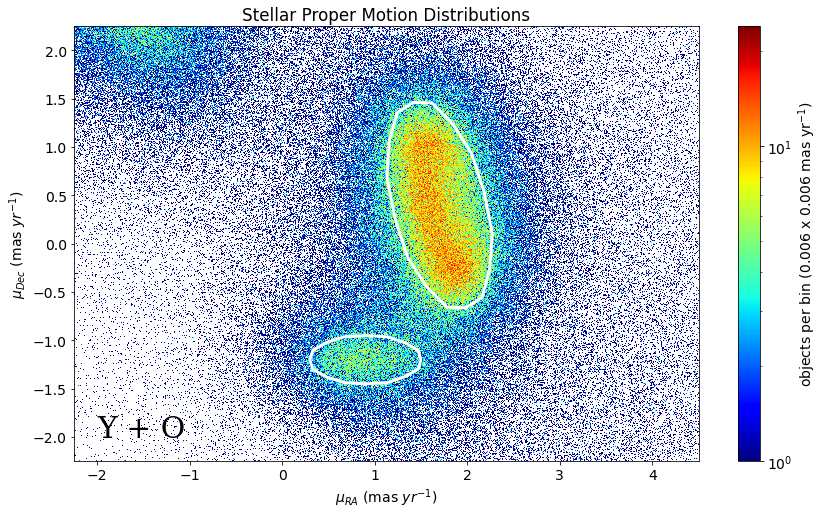

In [18]:
x_YO = res_YO['pmra']
y_YO = res_YO['pmdec']
extent = (-2.25,4.5,-2.25,2.25)
plot_pm_diagram(x_YO,y_YO,extent=None,binsize=0.006)

Compare this plot to Figure 4 in [El Youssoufi et al. (2021)](https://arxiv.org/abs/2104.08054). It shows the stellar proper motions towards the direction of the MCs. Contained within the large and small ellipse are most of the objects with LMC and SMC proper motions, respectively. Many of the objects that fall outside of these ellipses belong to the Milky Way. Objects belonging to these two ellipses make up our morphology dataset, consisting of over 300,000 sources.

#### For each region, extract the points within the SMC and LMC proper motion ovals, the SMC oval only, and the LMC oval only.

In [19]:
%%time
# this cell will run for about 2 minutes

# Within only the SMC proper motion oval
x_YO_pm_SMC, y_YO_pm_SMC = extract_points_in_polygon(x_YO, y_YO, SMC_ellipse)
x_Y_pm_SMC, y_Y_pm_SMC = extract_points_in_polygon(res_Y['pmra'], res_Y['pmdec'], SMC_ellipse)
x_O_pm_SMC, y_O_pm_SMC = extract_points_in_polygon(res_O['pmra'], res_O['pmdec'], SMC_ellipse)

# Within only the LMC proper motion oval
x_YO_pm_LMC, y_YO_pm_LMC = extract_points_in_polygon(x_YO, y_YO, LMC_ellipse)
x_Y_pm_LMC, y_Y_pm_LMC = extract_points_in_polygon(res_Y['pmra'], res_Y['pmdec'], LMC_ellipse)
x_O_pm_LMC, y_O_pm_LMC = extract_points_in_polygon(res_O['pmra'], res_O['pmdec'], LMC_ellipse)

# SMC and LMC combined
x_YO_pm = x_YO_pm_SMC + x_YO_pm_LMC
y_YO_pm = y_YO_pm_SMC + y_YO_pm_LMC
x_Y_pm = x_Y_pm_SMC + x_Y_pm_LMC
y_Y_pm = y_Y_pm_SMC + y_Y_pm_LMC
x_O_pm = x_O_pm_SMC + x_O_pm_LMC
y_O_pm = y_O_pm_SMC + y_O_pm_LMC

CPU times: user 1min 19s, sys: 90.8 ms, total: 1min 19s
Wall time: 1min 19s


#### For each region, query the resulting tables from the previous section for corresponding data.

In [20]:
# Within only the SMC proper motion oval
res_YO_SMC = res_YO.query("pmra == @x_YO_pm_SMC and pmdec == @y_YO_pm_SMC")
res_Y_SMC = res_Y.query("pmra == @x_Y_pm_SMC and pmdec == @y_Y_pm_SMC")
res_O_SMC = res_O.query("pmra == @x_O_pm_SMC and pmdec == @y_O_pm_SMC")

# Within only the LMC proper motion oval
res_YO_LMC = res_YO.query("pmra == @x_YO_pm_LMC and pmdec == @y_YO_pm_LMC")
res_Y_LMC = res_Y.query("pmra == @x_Y_pm_LMC and pmdec == @y_Y_pm_LMC")
res_O_LMC = res_O.query("pmra == @x_O_pm_LMC and pmdec == @y_O_pm_LMC")

# Within both the SMC and LMC proper motion ovals
res_YO_MC = res_YO.query("pmra == @x_YO_pm and pmdec == @y_YO_pm")
res_Y_MC = res_Y.query("pmra == @x_Y_pm and pmdec == @y_Y_pm")
res_O_MC = res_O.query("pmra == @x_O_pm and pmdec == @y_O_pm")

In [21]:
res_YO_MC

,ra_vhs,dec_vhs,jmkspnt,ksapermag3,parallax,pmra,pmdec
19,340.882836,-43.074753,0.500894,13.601856,0.050497,0.733171,-1.282724
109,342.472302,-43.069447,0.529795,15.507081,0.036583,0.553468,-1.150829
140,340.831002,-41.901382,0.243515,17.647948,0.056788,1.377986,0.618105
287,342.685963,-43.188590,0.323425,17.490042,-0.020074,0.731199,-1.361137
332,344.935758,-43.492986,0.358471,17.694826,-1.142791,0.895003,-1.280528
...,...,...,...,...,...,...,...
1403915,49.553440,-40.403314,0.485857,16.384520,0.069227,1.922725,0.579708
1403953,50.404652,-40.161298,0.621100,15.807586,-0.005558,1.760515,0.218028
1403988,48.430879,-40.207974,0.583345,17.429646,0.034430,1.377512,-0.009441
1404045,40.639221,-40.782657,0.426798,16.552079,0.178402,1.298729,1.118833


<a class="anchor" id="spatmorph"></a>
## Morphology maps of the spatial density of Y, O, and Y+O stars
Next, we will construct the morphology maps of the spatial density of Young, Old, and Young+Old stars using LMC, SMC, and LMC or SMC proper motion selections.
First, perform the transformation of coordinates from angular to Cartesian via a zenithal equidistant projection with a projection origin of `ra0=81.24 deg` and `dec0=-69.73 deg` corresponding to the densest point in the LMC bar ([de Vaucouleurs & Freeman 1972](https://ui.adsabs.harvard.edu/abs/1972VA.....14..163D/abstract)).

In [22]:
def zenithal_equidistant_projection(ra,dec):
    """
    Performs the transformation of coordinates from angular to Cartesian
    via a zenithal equidistant projection given a particular point to be
    the origin of analysis (ra0, dec0).
    """
    ra0 = 81.24 * (np.pi/180)   # convert to radians
    dec0 = -69.73 * (np.pi/180)
    ra = ra * (np.pi/180)
    dec = dec * (np.pi/180)
    
    c = np.arccos( (np.sin(dec0)*np.sin(dec)) + (np.cos(dec0)*np.cos(dec)*np.cos(ra-ra0)) )
    k = c/(np.sin(c))
    x = k * np.cos(dec) * np.sin(ra-ra0)
    y = k * ( (np.cos(dec0)*np.sin(dec)) - (np.sin(dec0)*np.cos(dec)*np.cos(ra-ra0)) )

    X = x * (180/np.pi)   # convert back into degrees
    Y = y * (180/np.pi)
    
    return X,Y

In [23]:
# Within only the SMC proper motion oval
res_YO_SMC_X,res_YO_SMC_Y = zenithal_equidistant_projection(res_YO_SMC['ra_vhs'],res_YO_SMC['dec_vhs'])
res_Y_SMC_X,res_Y_SMC_Y = zenithal_equidistant_projection(res_Y_SMC['ra_vhs'],res_Y_SMC['dec_vhs'])
res_O_SMC_X,res_O_SMC_Y = zenithal_equidistant_projection(res_O_SMC['ra_vhs'],res_O_SMC['dec_vhs'])

# Within only the LMC proper motion oval
res_YO_LMC_X,res_YO_LMC_Y = zenithal_equidistant_projection(res_YO_LMC['ra_vhs'],res_YO_LMC['dec_vhs'])
res_Y_LMC_X,res_Y_LMC_Y = zenithal_equidistant_projection(res_Y_LMC['ra_vhs'],res_Y_LMC['dec_vhs'])
res_O_LMC_X,res_O_LMC_Y = zenithal_equidistant_projection(res_O_LMC['ra_vhs'],res_O_LMC['dec_vhs'])

# Within both the SMC and LMC proper motion ovals
res_YO_MC_X,res_YO_MC_Y = zenithal_equidistant_projection(res_YO_MC['ra_vhs'],res_YO_MC['dec_vhs'])
res_Y_MC_X,res_Y_MC_Y = zenithal_equidistant_projection(res_Y_MC['ra_vhs'],res_Y_MC['dec_vhs'])
res_O_MC_X,res_O_MC_Y = zenithal_equidistant_projection(res_O_MC['ra_vhs'],res_O_MC['dec_vhs'])

#### Adding elliptical masks
Here we define two ellipses that will mask the central region of the LMC and SMC to enhance the distribution of stars in the outer regions. We will only want to keep the periphery points (i.e. points that are not contained within the ellipses) for further analysis.

In [24]:
LMC_mask = Ellipse((0,0.5),12,14,0)        # ((x_center, y_center), width, height, angle)
LMC_vertices = LMC_mask.get_verts()        # get the vertices from the ellipse object
LMC_mask = Polygon(LMC_vertices)           # Turn it into a polygon

SMC_mask = Ellipse((-16,-13.5),7.5,7.5,0)  # ((x_center, y_center), width, height, angle)
SMC_vertices = SMC_mask.get_verts()        # get the vertices from the ellipse object
SMC_mask = Polygon(SMC_vertices)           # Turn it into a polygon

In [25]:
def periphery(deg_coords_X, deg_coords_Y, MC_poly1, MC_poly2):
    '''
    Given the RA/Dec coordinates and two Polygons (masks),
    keep only the RA/Dec coordinates that fall outside of
    the masks.
    '''
    periph_points = []
    periph_x = []
    periph_y = []
    xy_coords = [Point(x,y) for x,y in zip(deg_coords_X,deg_coords_Y)]
    for p in xy_coords:
        if not p.within(MC_poly1) and not p.within(MC_poly2):
            periph_points.append(p)
    for i in range(len(periph_points)):
        periph_x1 = periph_points[i].xy[0][0]   # get the x coordinate from periph_points
        periph_y1 = periph_points[i].xy[1][0]   # get the y coordinate from periph_points
        periph_x.append(periph_x1)
        periph_y.append(periph_y1)
    return periph_x, periph_y

#### Get the periphery points for Y+O, Y, and O regions

In [ ]:
%%time
# this cell will run for about 2 minutes

# Within both the SMC and LMC proper motion ovals
periph_YO_MC_x, periph_YO_MC_y = periphery(res_YO_MC_X, res_YO_MC_Y, LMC_mask, SMC_mask)
periph_Y_MC_x, periph_Y_MC_y = periphery(res_Y_MC_X, res_Y_MC_Y, LMC_mask, SMC_mask)
periph_O_MC_x, periph_O_MC_y = periphery(res_O_MC_X, res_O_MC_Y, LMC_mask, SMC_mask)

# Within only the SMC proper motion oval
periph_YO_SMC_x, periph_YO_SMC_y = periphery(res_YO_SMC_X, res_YO_SMC_Y, LMC_mask, SMC_mask)
periph_Y_SMC_x, periph_Y_SMC_y = periphery(res_Y_SMC_X, res_Y_SMC_Y, LMC_mask, SMC_mask)
periph_O_SMC_x, periph_O_SMC_y = periphery(res_O_SMC_X, res_O_SMC_Y, LMC_mask, SMC_mask)

# Within only the LMC proper motion oval
periph_YO_LMC_x, periph_YO_LMC_y = periphery(res_YO_LMC_X, res_YO_LMC_Y, LMC_mask, SMC_mask)
periph_Y_LMC_x, periph_Y_LMC_y = periphery(res_Y_LMC_X, res_Y_LMC_Y, LMC_mask, SMC_mask)
periph_O_LMC_x, periph_O_LMC_y = periphery(res_O_LMC_X, res_O_LMC_Y, LMC_mask, SMC_mask)

In [ ]:
def plot_spatden(x1,y1,x2,y2,x3,y3,mc):
    '''
    Given the x and y (RA and Dec) coordinates of three different
    regions and the name of the MC (either SMC or LMC, or empty
    string), plot three spatial density morphology maps.
    '''
    fig, axs = plt.subplots(1,3, figsize = (25,25), sharey = False, sharex = False)
    hist1, xedges1, yedges1 = np.histogram2d(x1, y1, bins=130)
    hist2, xedges2, yedges2 = np.histogram2d(x2, y2, bins=130)
    hist3, xedges3, yedges3 = np.histogram2d(x3, y3, bins=130)
    extent1 = [xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]]
    extent2 = [xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]]
    extent3 = [xedges3[0], xedges3[-1], yedges3[0], yedges3[-1]]

    r1 = axs[0].imshow(hist1.T,
               extent=extent1,
               origin='lower',
               interpolation='spline16',
               cmap=plt.get_cmap('jet', 15), # use nicer color map
               vmax=15,)
    r2 = axs[1].imshow(hist2.T,
               extent=extent2,
               origin='lower',
               interpolation='spline16',
               cmap=plt.get_cmap('jet', 15), # use nicer color map
               vmax=15,)
    r3 = axs[2].imshow(hist3.T,
               extent=extent3,
               origin='lower',
               interpolation='spline16',
               cmap=plt.get_cmap('jet', 15), # use nicer color map
               vmax=15,)

    for i in range(3):
        cbar = fig.colorbar(r1,ax=axs[i],shrink=0.21, label='Number of stars per bin')
        cbar.set_ticks([0, 3, 6, 9, 12, 15])
        axs[i].set_ylabel('$\Delta$ Dec (deg)')
        axs[i].set_xlabel('$\Delta$ RA (deg)')
        axs[i].set_xlim(20,-30)
        axs[i].set_ylim(-24,20)
    
    axs[0].text(-19,15,'Y+O',fontsize=30,color='w',family='serif')
    axs[1].text(-25,15,'Y',fontsize=30,color='w',family='serif')
    axs[2].text(-25,15,'O',fontsize=30,color='w',family='serif')
    
    if mc == 'LMC':
        for i in range(3):
            axs[i].text(-21,11,'LMC',fontsize=20,color='w',family='serif')
    elif mc == 'SMC':
        for i in range(3):
            axs[i].text(-21,11,'SMC',fontsize=20,color='w',family='serif')
            
    plt.show()

In [ ]:
plot_spatden(periph_YO_MC_x, periph_YO_MC_y, periph_Y_MC_x, periph_Y_MC_y, periph_O_MC_x, periph_O_MC_y, mc='MC')
plot_spatden(periph_YO_LMC_x, periph_YO_LMC_y, periph_Y_LMC_x, periph_Y_LMC_y, periph_O_LMC_x, periph_O_LMC_y, mc='LMC')
plot_spatden(periph_YO_SMC_x, periph_YO_SMC_y, periph_Y_SMC_x, periph_Y_SMC_y, periph_O_SMC_x, periph_O_SMC_y, mc='SMC')

Morphology maps of young and old stars (Y+O; left) surrounding the MCs, young stars (Y; middle) dominated by top of main sequence and supergiant stars, and old stars (O; right) dominated RGB and RC stars. The three rows show stars selected based on LMC or SMC proper motions (top), LMC proper motions (middle) and SMC proper motions (bottom). The color bars show the number of stars per bin. The central regions of the LMC and SMC have been masked out to emphasize the distribution of stars in the outer regions.

# Resources & references

Interpolations for imshow: https://matplotlib.org/stable/gallery/images_contours_and_fields/interpolation_methods.html  
Shapely: https://shapely.readthedocs.io/en/stable/manual.html  
Azimuthal Equidistant Projection: https://mathworld.wolfram.com/AzimuthalEquidistantProjection.html

Cioni et al. (2014): https://arxiv.org/abs/1306.4336  
Cioni et al. (2016): https://arxiv.org/abs/1510.07647  
El Youssoufi et al. (2019): https://arxiv.org/abs/1908.08545  
El Youssoufi et al. (2021): https://arxiv.org/abs/2104.08054  